In [13]:
import warnings
warnings.filterwarnings('ignore') # 忽略警告
import pandas as pd
from pandas import IndexSlice as idx
pd.set_option('display.max_columns', None)  # 当列太多时不换行
# df = pd.read_pickle('cb_data.pq') # 导入转债数据
# index = pd.read_pickle('index.pq') # 导入指数数据
df = pd.read_parquet('cb_data.pq') # 导入转债数据
index = pd.read_parquet('index.pq') # 导入指数数据

In [4]:
# 基础设置
start_date = '20220801' # 开始日期
end_date = '20230901' # 结束日期
hold_num = 10 # 持有数量
SP = 0.06 # 盘中止盈条件
c_rate =  1 / 10000 # 买卖一次花费的总佣金和滑点（双边）
benchmark = 'index_jsl' # 选择基准，集思录等权:index_jsl, 沪深300:index_300, 中证1000:index_1000, 国证2000:index_2000

In [5]:
# 排除设置
df = df[(df.index.get_level_values('trade_date') >= start_date) & (df.index.get_level_values('trade_date') <= end_date)] # 选择时间范围内数据
df['filter'] = False # 初始化过滤器
df.loc[df.is_call.isin(['已公告强赎', '公告到期赎回','公告实施强赎', '公告提示强赎', '已满足强赎条件']), 'filter'] = True # 排除赎回状态
df.loc[df.close > 150, 'filter'] = True # 排除收盘价大于150的标的
df.loc[df.close < 100, 'filter'] = True # 排除收盘价小于100的标的
df.loc[df.list_days <= 3, 'filter'] = True # 排除新债

In [6]:
# 计算三低值
df['SDZ']=(df.loc[df['filter'] == False,'close'] *(1+df.loc[df['filter'] == False,'conv_prem'])  * df.loc[df['filter'] == False,'remain_size'])
df['rank'] = df.groupby('trade_date')['SDZ'].rank('first', ascending=True) # 按总分从高到低计算排名

In [7]:
code_group = df.groupby('code')
# (2)次日止盈条件
df['aft_open'] = code_group.open.shift(-1) # 计算次日开盘价
df['aft_close'] = code_group.close.shift(-1) # 计算次日收盘价
df['aft_high'] = code_group.high.shift(-1) # 计算次日最高价
df['time_return']= code_group.pct_chg.shift(-1) # 先计算不止盈情况的收益率
df['SFZY']='未满足止盈' #先记录默认情况
pd.set_option('display.max_columns', None)  # 当列太多时不换行

In [8]:
df.loc[df['aft_high'] >= df['close'] * (1+SP),'time_return'] = SP # 满足止盈条件止盈
df.loc[df['aft_open'] >= df['close'] * (1+SP),'time_return'] = \
(df['aft_open']-df['close'])/df['close'] # 开盘满足止盈条件则按开盘价计算涨幅
df.loc[df['aft_high'] >= df['close'] * (1+SP),'SFZY'] = '满足止盈'

In [9]:
# 计算每日信号 采样信号 持仓状态
df.loc[(df['rank'] <= hold_num), 'signal'] = 1 # 标记信号
df.dropna(subset=['signal'], inplace=True) # 删除没有标记的行
df.sort_values(by='trade_date', inplace=True) # 按日期排序

In [10]:
# 计算组合回报
res = pd.DataFrame()
res['time_return'] = df.groupby('trade_date')['time_return'].mean() # 按等权计算组合回报
pd.set_option('display.max_rows',None)
# 计算手续费
pos_df = df['signal'].unstack('code')
pos_df.fillna(0, inplace=True)
res['cost'] = pos_df.diff().abs().sum(axis=1) * c_rate / (pos_df.shift().sum(axis=1) + pos_df.sum(axis=1))
res.iloc[0, 1] = 0.5 * c_rate# 修正首行手续费
res['time_return'] = (res['time_return'] + 1) * (1 - res['cost']) - 1# 扣除手续费及佣金后的回报

                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2022-08-01  2022-08-01
End Period                 2023-09-01  2023-09-01
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      98.0%

Cumulative Return          19.79%      -6.97%
CAGR﹪                     18.11%      -6.44%

Sharpe                     1.32        -0.67
Prob. Sharpe Ratio         91.11%      24.5%
Smart Sharpe               1.11        -0.56
Sortino                    1.99        -0.88
Smart Sortino              1.67        -0.74
Sortino/√2                 1.41        -0.62
Smart Sortino/√2           1.18        -0.52
Omega                      1.25        1.25

Max Drawdown               -10.39%     -12.12%
Longest DD Days            148         379
Volatility (ann.)          13.64%      9.55%
R^2                        0.04        0.04
Information Ratio          0.1         0.1
Calmar                     1.74     

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2022-08-11,2022-09-30,2023-01-06,148,-10.392338,-9.953598
2,2023-04-07,2023-05-11,2023-06-02,56,-5.290132,-4.863271
3,2023-07-31,2023-08-24,2023-09-01,32,-4.843452,-4.643411
4,2023-02-13,2023-02-24,2023-03-08,23,-3.066332,-3.064519
5,2023-03-22,2023-03-29,2023-04-06,15,-2.110378,-1.886028


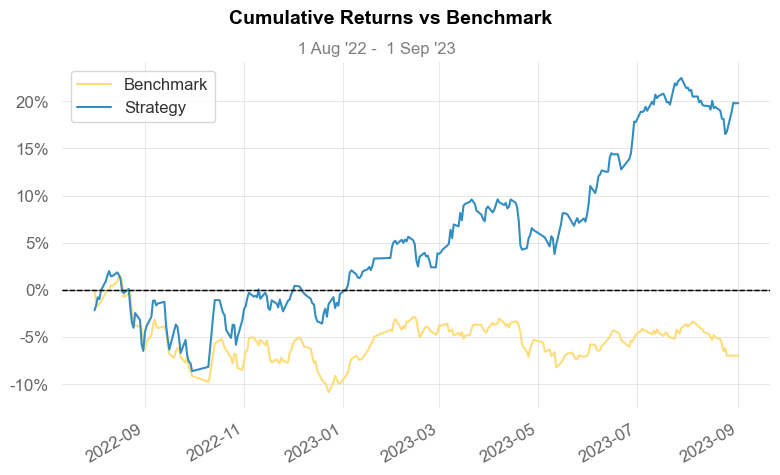

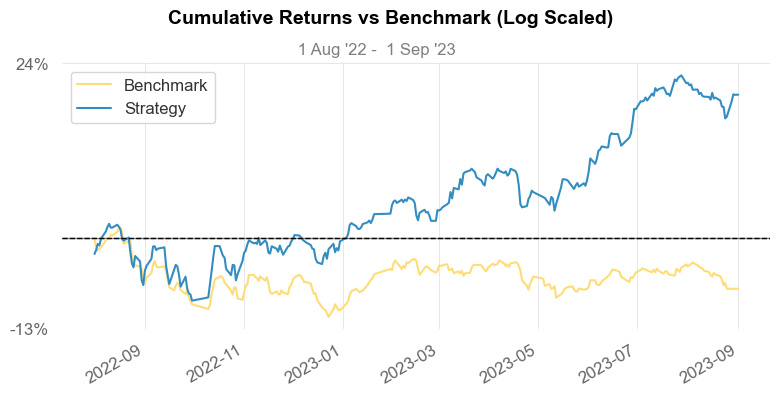

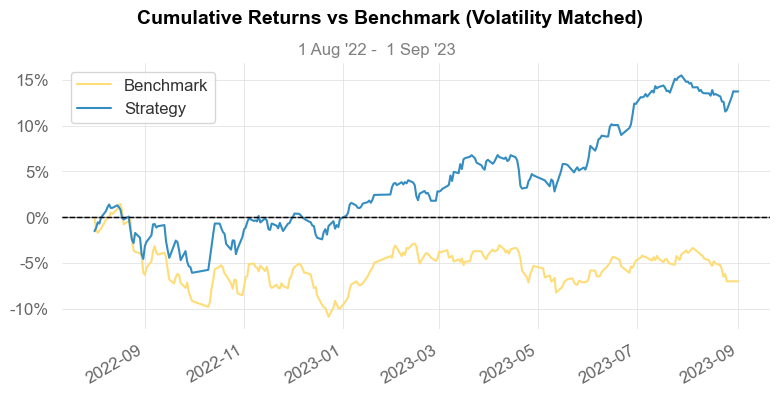

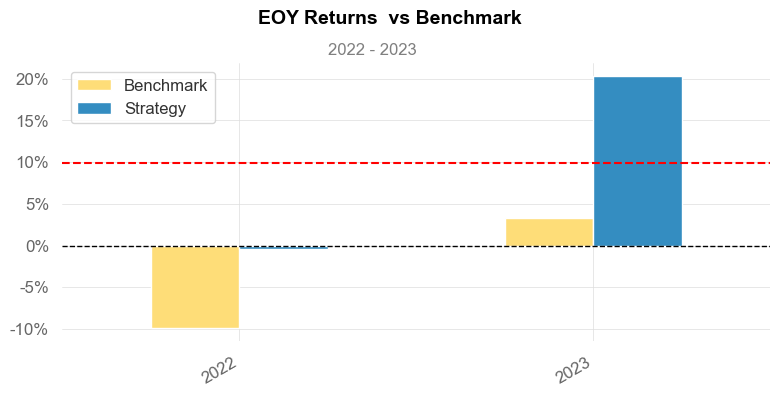

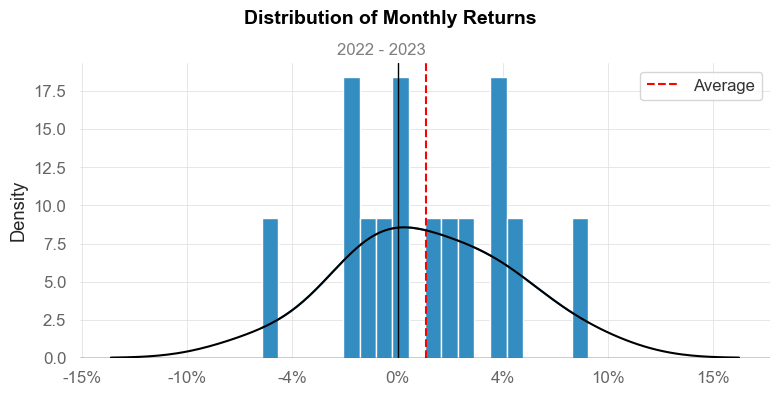

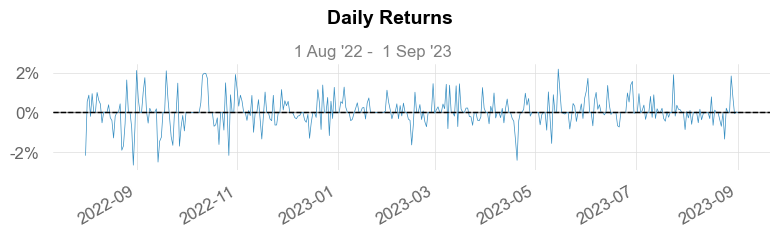

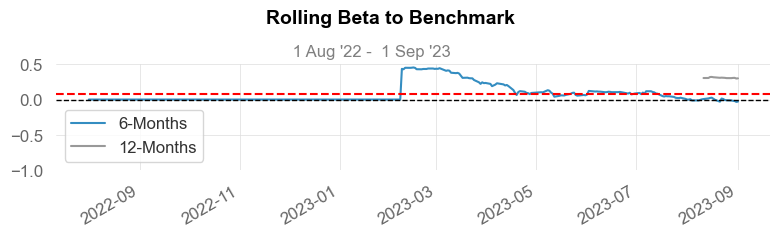

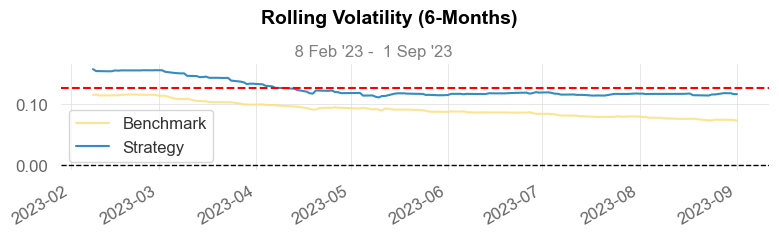

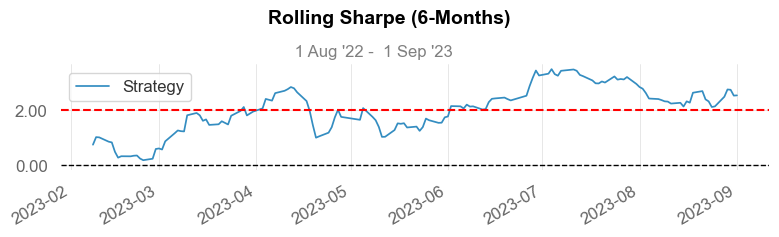

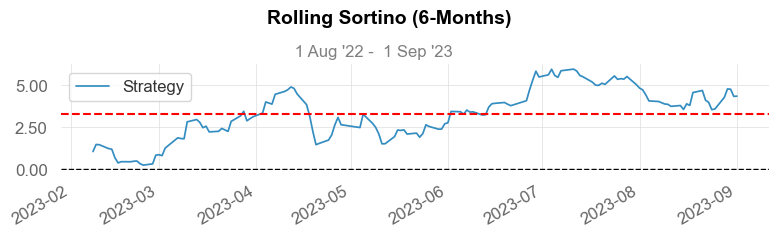

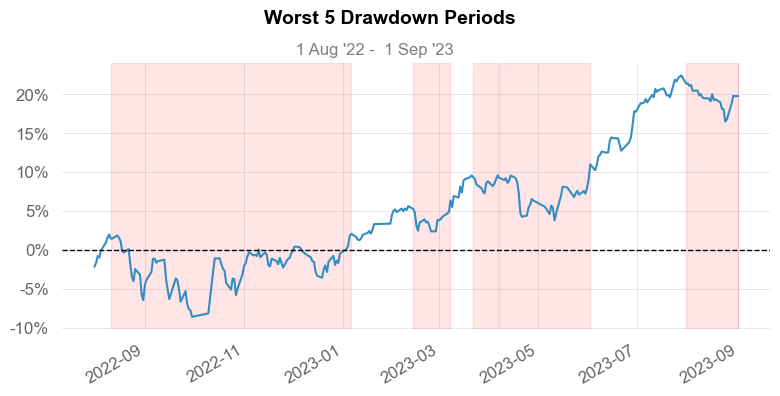

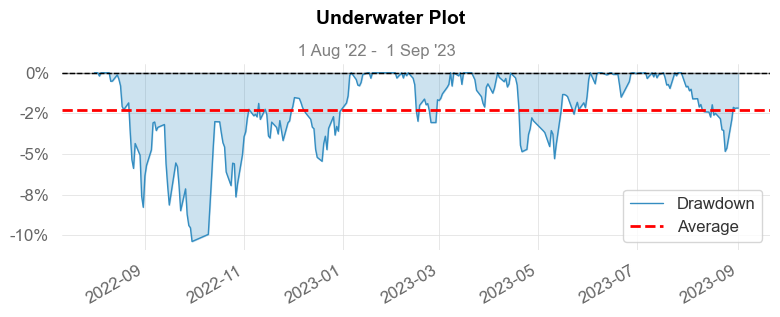

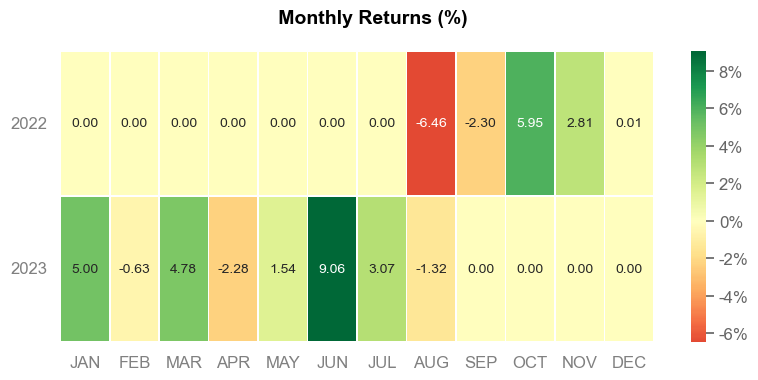

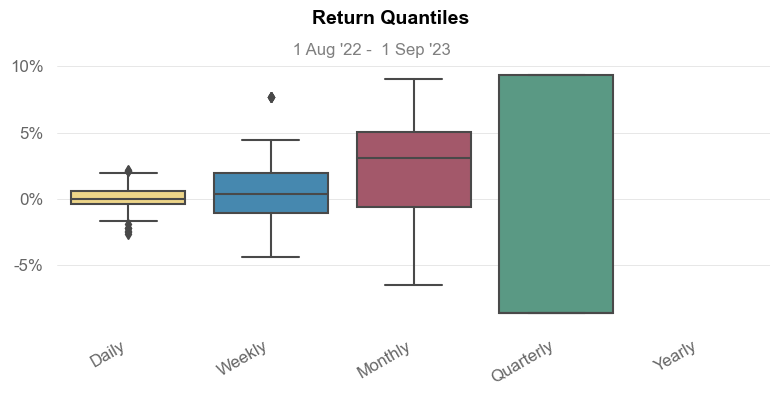

In [11]:
# 用quantstats生成评价报告
import quantstats as qs
qs.reports.full(res.time_return, benchmark=index[benchmark])

In [10]:
# 查看某个交易日选出的标的
df.loc[idx[:,'2023-01-20'],:].sort_values(by='rank') # 查看某日

,,name,pre_close,open,high,low,close,pct_chg,vol,amount,code_stk,name_stk,pre_close_stk,open_stk,high_stk,low_stk,close_stk,pct_chg_stk,vol_stk,amount_stk,pe_ttm,pb,ps_ttm,total_share,float_share,total_mv,circ_mv,volatility_stk,is_call,conv_price,conv_value,conv_prem,dblow,issue_size,remain_size,remain_cap,turnover,cap_mv_rate,list_date,list_days,conv_start_date,left_conv_start_days,conv_end_date,left_years,ytm,pure_value,bond_prem,option_value,theory_value,theory_bias,rating,yy_rating,orgform,area,industry_1,industry_2,industry_3,popularity_ranking,theory_conv_prem,mod_conv_prem,filter,SDZ,rank,aft_open,aft_close,aft_high,time_return,SFZY,signal
code,trade_date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
123014.SZ,2023-01-20,凯发转债,134.220,134.225,134.699,133.900,134.270,0.000373,4184.0,562.354097,300407.SZ,凯发电气,7.78,7.79,7.87,7.79,7.84,0.007712,14797.00,11595.910,33.2810,1.6832,1.2369,30510.5075,21294.6016,23.920238,16.694968,0.373874,,8.03,97.633873,0.375240,171.793992,3.4989,1.160285,1.557915,0.036097,0.065130,2018-08-21,1614,2019-02-11,-1439,2023-07-26,0.515068,-0.369630,102.008646,0.316261,9.930939,111.939584,0.166310,A+,8,民营企业,天津,电气设备,输变电设备,电气自控设备,271,0.276094,0.099146,False,214.250645,1.0,134.600,134.966,135.149,0.005184,未满足止盈,1.0
123052.SZ,2023-01-20,飞鹿转债,136.300,136.100,136.889,136.100,136.513,0.001563,5972.0,816.119993,300665.SZ,飞鹿股份,7.79,7.80,7.85,7.76,7.80,0.001284,13322.00,10396.789,NaN,2.5111,2.4628,19072.3885,13437.4791,14.876463,10.481234,0.383481,公告不强赎,7.08,110.169492,0.239118,160.424800,1.7700,1.503349,2.052267,0.039767,0.137954,2020-07-03,932,2020-12-11,-770,2026-06-04,3.375342,-0.024082,95.506689,0.429355,37.933915,133.440603,0.022506,A+,8-,民营企业,湖南,基础化工,化学制品,涂料涂漆,310,0.189154,0.049964,False,254.300076,2.0,136.671,137.376,137.550,0.006322,未满足止盈,1.0
123080.SZ,2023-01-20,海波转债,145.252,145.500,148.148,145.500,147.800,0.017542,32406.0,4762.727005,300517.SZ,海波重科,14.51,14.58,14.75,14.47,14.60,0.006203,23895.29,34854.759,47.2147,2.8361,4.3251,20038.2344,12398.8544,29.255822,18.102327,0.526301,公告不强赎,11.53,126.626193,0.167215,164.521507,2.4500,1.489490,2.201466,0.216343,0.075249,2020-12-22,760,2021-06-08,-591,2026-12-01,3.868493,-0.042797,90.756579,0.628532,62.983159,153.739738,-0.040188,A+,8,民营企业,湖北,建筑,基础建设,路桥建设,112,0.115134,0.052082,False,256.958454,3.0,148.096,148.410,150.690,0.004127,未满足止盈,1.0
113561.SH,2023-01-20,正裕转债,123.305,123.310,124.373,123.310,124.161,0.006942,4888.0,605.594000,603089.SH,正裕工业,8.85,8.86,8.96,8.82,8.89,0.004520,16714.00,14844.474,23.6486,1.7855,1.0985,22250.1003,22250.1003,19.780339,19.780339,0.419936,,9.98,89.078156,0.393843,163.545340,2.9000,1.498980,1.861149,0.032539,0.094091,2020-02-10,1076,2020-07-07,-927,2025-12-30,2.947945,-0.023203,91.088615,0.363079,23.811811,114.900426,0.074585,A+,,民营企业,浙江,交运设备,汽车,汽车零部件,290,0.357400,0.036444,False,259.414963,4.0,125.161,125.316,125.870,0.009302,未满足止盈,1.0
128079.SZ,2023-01-20,英联转债,143.600,143.600,147.200,143.600,144.577,0.006804,100243.5,14567.796894,002846.SZ,英联股份,9.51,9.51,9.74,9.51,9.64,0.013670,46370.54,44726.555,NaN,3.9109,1.5852,31842.0980,22281.4993,30.695782,21.479365,0.559054,,8.29,116.284680,0.243302,168.907221,2.1400,1.516302,2.192224,0.664521,0.071418,2019-11-21,1157,2020-04-27,-998,2025-10-20,2.753425,-0.078473,92.543436,0.562261,49.947690,142.491126,0.014427,A+,,民营企业,广东,轻工制造,造纸印刷,包装印刷,37,0.157288,0.086014,False,272.559687,5.0,145.900,147.168,147.738,0.017921,未满足止盈,1.0
113566.SH,2023-01-20,翔港转债,121.647,121.501,122.266,121.501,121.890,0.001998,4644.0,566.267500,603499.SH,翔港科技,9.33,9.28,9.38,9.20,9.33,0.000000,19523.72,18126.229,NaN,3.3400,2.9000,20115.3443,20115.3443,18.767616,18.767616,0.417151,,10.77,86.629526,0.407026,162.592605,2.0000,1.612720,1.965744,0.028807,0.104741,2020-03-31,1026,2020-09-07,-865,2026-02-27,3.109589,0.003534,95.544407,0.275742,22.923344,118.467750,0.028077,A+,,民营企业,上海,轻工制造,造纸印刷,包装印刷,421,0.384801,0.022225,False,276.585358,6.0,121.876,123.889,124.890,0.016400,未满足止盈,1.0
113567.SH,2023-01-20,君禾